In [12]:
import numpy as np

from system import (
    s_state,
    t_state,
    rows,
    cols,
    states,
    num_states,
    num_actions,
    wind_col,
    to_idx,
    get_valid_actions,
    init_mdp,
    init_reward,
)
from model import Model
from policy import Policy, PolicyInit
from agent import Agent

In [13]:
def EvaluatePolicy(
    policy: Policy, valf: np.ndarray, model: Model, thresh=0.01, gamma=1.0
):
    i = 0
    delta = thresh + 1
    while delta > thresh and i < 1000:
        delta = 0
        for s in states:
            v = valf[to_idx(s)]
            a = policy.get_action(s)

            valf[to_idx(s)] = model.prob(s, a) @ (model.get_reward(s) + gamma * valf)

            delta = max(delta, abs(v - valf[to_idx(s)]))
        i += 1
    return valf

In [14]:
def UpdatePolicy(policy: Policy, valf: np.ndarray, model: Model, gamma=1.0):
    policy_stable = True
    k = 0
    changed_policies = []
    for s in states:
        old_action = policy.get_action(s)
        valid_actions_idx = get_valid_actions(s)
        action_value = [
            model.prob(s, a) @ (model.get_reward(s) + gamma * valf)
            for a in valid_actions_idx
        ]
        amzt = valid_actions_idx[np.argmax(action_value)]

        if valf[to_idx(s)] <= np.max(action_value):
            policy.set_action(s, amzt)
            if old_action != policy.get_action(s):
                policy_stable = False
                changed_policies.append(s)
                k += 1
    return policy_stable

In [15]:
# Initialize model
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_state=np.array([3, 7]), t_reward=0)
model = Model(mdp, reward)

# Initialize policy
policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

In [16]:
# Initialize random state function
valf = np.random.uniform(0, 2, size=num_states)
valf_store = []
valf_store.append(valf.copy())
valstart = []
thresh = 0.001
gamma = 0.9

policy_stable = False
i = 0
while (not policy_stable) and i < 1000:
    print(f"Policy Iteration {i + 1}")

    # Policy Evaluation
    print("Evaluating Policy")
    valf = EvaluatePolicy(policy, valf, model, thresh, gamma)
    valf_store.append(valf)
    valstart.append(valf[to_idx(s_state)])

    # Policy Improvement
    print("Updating Policy")
    policy_stable = UpdatePolicy(policy, valf, model, gamma)
    i += 1

Policy Iteration 1
Evaluating Policy
Updating Policy
Policy Iteration 2
Evaluating Policy
Updating Policy
Policy Iteration 3
Evaluating Policy
Updating Policy
Policy Iteration 4
Evaluating Policy
Updating Policy
Policy Iteration 5
Evaluating Policy
Updating Policy
Policy Iteration 6
Evaluating Policy
Updating Policy
Policy Iteration 7
Evaluating Policy
Updating Policy
Policy Iteration 8
Evaluating Policy
Updating Policy


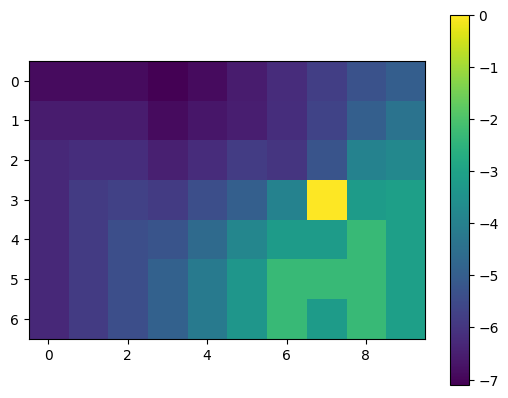

In [17]:
import matplotlib.pyplot as plt

valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

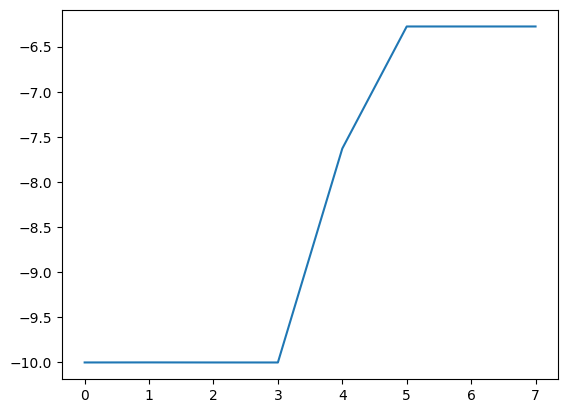

In [18]:
valstart = np.array(valstart)
plt.plot(valstart)

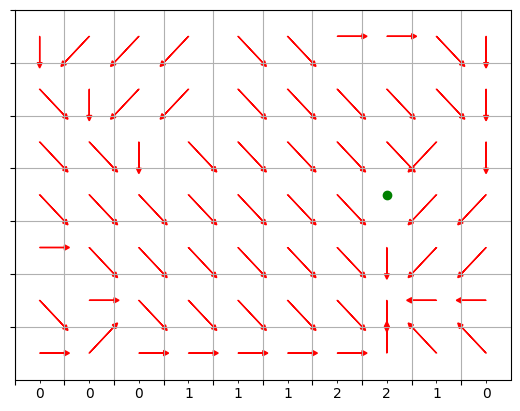

In [19]:
ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

# ## plot 8 types arrows in each grid cell corresponding to the action in the optimal policy
# 0: up-left, 1:up, 2: up-right, 3: left,4: right,5:down-left,6:down,7:down-right
for i in range(rows):
    for j in range(cols):
        s = np.array([i, j])
        action = policy.get_action(s)
        x_start = j + 0.5  # x-coordinate shifted to the middle of the grid cell
        y_start = i + 0.5  # y-coordinate shifted to the middle of the grid cell
        
        if action == 0:
            plt.arrow(x_start, y_start, -0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 1:
            plt.arrow(x_start, y_start, 0, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 2:
            plt.arrow(x_start, y_start, 0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 3:
            plt.arrow(x_start, y_start, -0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 4:
            plt.arrow(x_start, y_start, 0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 5:
            plt.arrow(x_start, y_start, -0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 6:
            plt.arrow(x_start, y_start, 0, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 7:
            plt.arrow(x_start, y_start, 0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 8:
            plt.plot(x_start, y_start, 'go')            


In [20]:
agent = Agent(model, policy)
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [1 1], Next State: [6 3], Reward: -1
State: [6 3], Action: [0 1], Next State: [6 4], Reward: -1
State: [6 4], Action: [0 1], Next State: [4 5], Reward: -1
State: [4 5], Action: [1 1], Next State: [4 6], Reward: -1
State: [4 6], Action: [1 1], Next State: [3 7], Reward: 0
Game Over - Score: -6


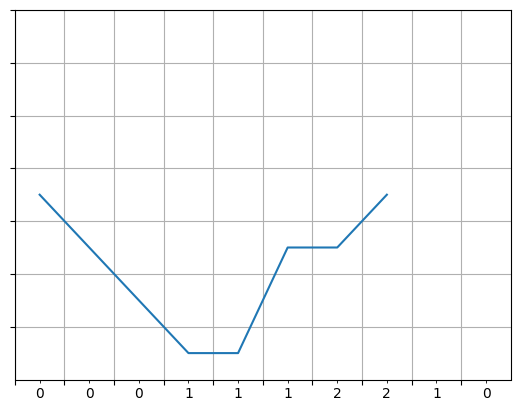

In [21]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()